In [1]:
import requests
from dotenv import load_dotenv
import os
import pandas as pd
import steamspypi
import steamreviews
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



load_dotenv()
API_KEY = os.getenv("API_KEY")


# Collect the 100 most popular games on steam

In [ ]:
data_request = {"request": "top100owned"}
data = steamspypi.download(data_request)
df = pd.DataFrame(data.values())
df = df[['name', 'appid']]
display(df.head())


In [ ]:
def get_tags(appid):
    data_request = {"request": "appdetails", "appid": appid}
    data = steamspypi.download(data_request)
    return data['tags']

df['tags'] = df['appid'].apply(get_tags)

print(df)

# Construct player networks

Does it make sense to prune the friends of seed players based on wether they have the original game or not? The two options are smartly choosing the seed players or recursively looking at friends of friends who have the game until we have a big enough network.

In [ ]:
def get_friends_with_game(player_id, app_id):
    """ 
    Given a player_id and an app_id, returns a list of the player's friends who own the game.
    """
    all_friends = []
    url = f'http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key={API_KEY}&steamid={player_id}&relationship=friend'
    response = requests.get(url)
    friend_list = response.json()
    try:
        for item in friend_list["friendslist"]["friends"]:
            all_friends.append(item["steamid"])
    except:
        pass
        # print("Error getting friends.")
    friends_with_game = []
    for friend in all_friends:
        games = []
        url = f'http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key={API_KEY}&steamid={friend}&format=json'
        response = requests.get(url)
        game_list = response.json()
        try:
            for item in game_list["response"]["games"]:
                games.append(item["appid"])
        except:
            continue
        if app_id in games:
            friends_with_game.append(friend)
    return friends_with_game
    
def get_friends(player_id):
    """ 
    Given a player_id, returns a list of the player's friends.
    """
    all_friends = []
    url = f'http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key={API_KEY}&steamid={player_id}&relationship=friend'
    response = requests.get(url)
    friend_list = response.json()
    try:
        for item in friend_list["friendslist"]["friends"]:
            all_friends.append(item["steamid"])
    except:
        pass
        # print("Error getting friends.")
    return all_friends    
    
def get_ownership_network(app_id, params, seed_size=10, min_net_size=100):
    """ 
    Given an app_id, returns a list of players who own the game and their friends who own the game.
    """
    # Get seed players
    review_dict, query_count = steamreviews.download_reviews_for_app_id(app_id, chosen_request_params=params)
    players = []
    for key in review_dict["reviews"].keys():
        if len(players) < seed_size:
            players.append(review_dict["reviews"][key]["author"]["steamid"])
    network = players.copy()
    queue = players.copy()
    while queue:
        player = queue.pop(0)
        friends = get_friends_with_game(player, app_id)
        for friend in friends:
            if friend not in network:
                network.append(friend)
                queue.append(friend)
                # print(f"Added {friend} to the network.")
                if len(network) >= min_net_size:
                    return network
    return network

def get_non_ownership_network(app_id, params, seed_size=10, min_net_size=100):
    """ 
    Given an app_id, returns a friendship network of seed players. Friends of seeded players don't necessarily own the game.
    """
    # Get seed players
    review_dict, query_count = steamreviews.download_reviews_for_app_id(app_id, chosen_request_params=params)
    players = []
    for key in review_dict["reviews"].keys():
        if len(players) < seed_size:
            players.append(review_dict["reviews"][key]["author"]["steamid"])
    print("Seed players collected.")      
    network = players.copy()
    queue = players.copy()
    while queue:
        player = queue.pop(0)
        friends = get_friends(player)
        for friend in friends:
            if friend not in network:
                network.append(friend)
                queue.append(friend)
                # print(f"Added {friend} to the network.")
                if len(network) >= min_net_size:
                    return network
    return network
        
        
def get_edges(net_nodes):
    edges = []
    for node in net_nodes:
        friends = get_friends(node)
        for friend in friends:
            if friend in net_nodes:
                edges.append((node, friend))
    return edges

def construct_pajek_network(net_nodes, net_edges, app_id):
    with open(f"./Networks/{app_id}.net", "w") as f:
        f.write("*Vertices " + str(len(net_nodes)) + "\n")
        for i, node in enumerate(net_nodes):
            f.write(str(i+1) + ' "' + node + '"\n')
        f.write("*Edges\n")
        for edge in net_edges:
            f.write(str(net_nodes.index(edge[0]) + 1) + " " + str(net_nodes.index(edge[1]) + 1) + "\n")
    
def construct_network(app_id, params, seed_size=10, min_net_size=100):
    net_nodes = get_non_ownership_network(app_id, params, seed_size, min_net_size)
    print("Nodes collected.")
    net_edges = get_edges(net_nodes)
    print("Edges collected.")
    construct_pajek_network(net_nodes, net_edges, app_id)
    print("Network constructed.")

In [ ]:
request_params = dict()
request_params['language'] = 'english'
request_params['review_type'] = 'positive'
request_params['purchase_type'] = 'steam'
request_params['day_range'] = '30'

In [ ]:
files = os.listdir("./Networks")
files = [file.split(".")[0] for file in files]
for row in df.iterrows():
    app_id = row[1]['appid']
    if str(app_id) not in files:
        print(f"Constructing network for {row[1]['name']}.")
        construct_network(app_id, request_params, 10, 10000)
    else:
        print(f"Network for {row[1]['name']} already exists.")

# Network Structure

Compare the overall structure of the friendship networks, including metrics like density, average degree, and assortativity. Are there significant differences in how connected or clustered the networks are based on the games?

In [ ]:
import networkx as nx
import os

files = os.listdir("./Networks")
for file in files:
    id = file.split(".")[0]
    G = nx.read_pajek(f"./Networks/{file}")
    G = nx.Graph(G)
    if G.number_of_nodes() == 0:
        continue
    clustering_coefficient = nx.average_clustering(G)
    avg_degree = sum(dict(G.degree()).values()) / len(G)
    density = nx.density(G)
    largest_cc = max(nx.connected_components(G), key=len)
    df.loc[df['appid'] == int(id), 'avg_degree'] = avg_degree
    df.loc[df['appid'] == int(id), 'density'] = density
    df.loc[df['appid'] == int(id), 'clustering_coefficient'] = clustering_coefficient
    df.loc[df['appid'] == int(app_id), 'largest_connected_component'] = len(largest_cc)
    
df.to_csv("steam_data.csv")    


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['avg_degree'], df['density'], df['clustering_coefficient'])
ax.set_xlabel('Average Degree')
ax.set_ylabel('Density')
ax.set_zlabel('Clustering Coefficient')

plt.show()


# Centrality Measures

 Investigate the centrality of nodes (players) within each network. Are there players who act as hubs or connectors within their respective communities? Do certain games tend to have more centralized or decentralized networks?

In [ ]:
files = os.listdir("./Networks")
df = pd.read_csv("steam_data.csv")
for file in files:
    id = file.split(".")[0]
    G = nx.read_pajek(f"./Networks/{file}")
    G = nx.Graph(G)
    if G.number_of_nodes() == 0:
        continue
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    df.loc[df['appid'] == int(id), 'degree_centrality'] = np.mean(list(degree_centrality.values()))
    df.loc[df['appid'] == int(id), 'closeness_centrality'] = np.mean(list(closeness_centrality.values()))
    df.loc[df['appid'] == int(id), 'betweenness_centrality'] = np.mean(list(betweenness_centrality.values()))
df.to_csv("steam_data.csv")

In [ ]:
fig, axs = plt.subplots(3, 1)
axs[0].hist(df['degree_centrality'], bins=72)
axs[0].set_title('Degree Centrality')
axs[1].hist(df['closeness_centrality'], bins=72)
axs[1].set_title('Closeness Centrality')
axs[2].hist(df['betweenness_centrality'], bins=72)
axs[2].set_title('Betweenness Centrality')
plt.tight_layout()
plt.show()

# Community Detection

Apply community detection algorithms to identify groups or communities within each network. Are there distinct community structures associated with different games? How do these communities overlap or interact?

# Visualization 


In [42]:
extraction_dir = 'Networks_100_1000'
#network_dir = os.path.join(extraction_dir, 'Networks_100_1000')
network_files = os.listdir(extraction_dir)
network_files

['413150.net',
 '438100.net',
 '304930.net',
 '578080.net',
 '755790.net',
 '550650.net',
 '532210.net',
 '10.net',
 '8930.net',
 '1097150.net',
 '945360.net',
 '1938090.net',
 '291480.net',
 '1623730.net',
 '1174180.net',
 '477160.net',
 '301520.net',
 '417910.net',
 '291550.net',
 '570.net',
 '252490.net',
 '582010.net',
 '1811260.net',
 '230410.net',
 '553850.net',
 '4000.net',
 '377160.net',
 '1086940.net',
 '251570.net',
 '105600.net',
 '386360.net',
 '250900.net',
 '239140.net',
 '431960.net',
 '70.net',
 '1245620.net',
 '444090.net',
 '400.net',
 '49520.net',
 '901583.net',
 '814380.net',
 '990080.net',
 '552990.net',
 '550.net',
 '1063730.net',
 '340.net',
 '381210.net',
 '1517290.net',
 '739630.net',
 '227940.net',
 '620.net',
 '218620.net',
 '1085660.net',
 '648800.net',
 '240.net',
 '730.net',
 '320.net',
 '359550.net',
 '892970.net',
 '1240440.net',
 '367520.net',
 '304050.net',
 '292030.net',
 '271590.net',
 '444200.net',
 '1203220.net',
 '242760.net',
 '440.net',
 '322330

In [ ]:
network_files_string = "','".join(network_files)

In [ ]:
network_files_string

In [ ]:
import scipy.stats as stats
def visualize_network(file_path, title):
    G = nx.read_pajek(file_path)
    plt.figure(figsize=(12, 12))
    nx.draw_spring(G, node_size=20, with_labels=False)
    plt.title(title)
    plt.show()
sample_files = ['730.net']
for file_name in sample_files:
    file_path = os.path.join(extraction_dir, file_name)
    visualize_network(file_path, f'Network: {file_name}')

In [ ]:
import os
def load_network(file_path):
    return nx.read_pajek(file_path)
def convert_to_simple_graph(G):
    H = nx.Graph()
    for u, v, data in G.edges(data=True):
        if H.has_edge(u, v):
            if 'weight' in data:
                H[u][v]['weight'] += data['weight']
            else:
                H[u][v]['weight'] += 1  
        else:
            if 'weight' in data:
                H.add_edge(u, v, **data)
            else:
                H.add_edge(u, v, weight=1)  
    return H
def check_connectivity(G):
    if len(G) == 0:
        return False
    return nx.is_connected(G)
def analyze_clustering(G):
    if len(G) == 0:
        return 0
    clustering_coefficients = nx.clustering(G)
    avg_clustering = sum(clustering_coefficients.values()) / len(clustering_coefficients)
    return avg_clustering
def degree_distribution(G):
    degrees = [degree for node, degree in G.degree()]
    return degrees
def visualize_network(G, title):
    if len(G) == 0:
        print(f"Cannot visualize network {title} because it is empty.")
        return
    plt.figure(figsize=(12, 12))
    nx.draw_spring(G, node_size=20, with_labels=False)
    plt.title(title)
    plt.show()
network_files = ['413150.net','438100.net','304930.net','578080.net','755790.net','550650.net','532210.net','10.net','8930.net','1097150.net','945360.net','1938090.net','291480.net','1623730.net','1174180.net','477160.net','301520.net','417910.net','291550.net','570.net','252490.net','582010.net','1811260.net','230410.net','553850.net','4000.net','377160.net','1086940.net','251570.net','105600.net','386360.net','250900.net','239140.net','431960.net','70.net','1245620.net','444090.net','400.net','49520.net','901583.net','814380.net']
results = []
for file_name in network_files:
    file_path = os.path.join(extraction_dir, file_name)
    G = load_network(file_path)
    G_simple = convert_to_simple_graph(G)
    connectivity = check_connectivity(G_simple)
    results.append((file_name, 'Connected', connectivity))
    avg_clustering = analyze_clustering(G_simple)
    results.append((file_name, 'Average Clustering Coefficient', avg_clustering))
    degrees = degree_distribution(G_simple)
    plt.figure()
    plt.hist(degrees, bins=30)
    plt.title(f"Degree Distribution: {file_name}")
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()
    visualize_network(G_simple, f'Network: {file_name}')
results_df = pd.DataFrame(results, columns=['Network', 'Metric', 'Value'])
results_df


In [ ]:
extraction_dir = 'Networks_100_1000'
network_files = ['413150.net','438100.net','304930.net','578080.net','755790.net','550650.net','532210.net','10.net','8930.net','1097150.net','945360.net','1938090.net','291480.net','1623730.net','1174180.net','477160.net','301520.net','417910.net','291550.net','570.net','252490.net','582010.net','1811260.net','230410.net','553850.net','4000.net','377160.net','1086940.net','251570.net','105600.net','386360.net','250900.net','239140.net','431960.net','70.net','1245620.net','444090.net','400.net','49520.net','901583.net','814380.net']

In [ ]:
results = []
hub_results = []
def identify_hubs(G, threshold=2):
    """
    Identify hubs in the graph. Hubs are nodes with a degree greater than
    a certain threshold times the average degree of the network.
    """
    if len(G) == 0:
        return []
    
    avg_degree = sum(dict(G.degree()).values()) / len(G)
    hubs = [node for node, degree in G.degree() if degree > threshold * avg_degree]
    return hubs
def visualize_hub_distribution(G, hubs, title):
    """
    Visualize the degree distribution of hubs in the network.
    """
    if not hubs:
        print(f"No hubs identified in network {title}.")
        return
    plt.figure()
    plt.hist([G.degree(node) for node in hubs], bins=30)
    plt.title(f"Hub Degree Distribution: {title}")
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()
for file_name in network_files:
    file_path = os.path.join(extraction_dir, file_name)
    G = load_network(file_path)
    G_simple = convert_to_simple_graph(G)
    hubs = identify_hubs(G_simple)
    hub_results.append((file_name, 'Number of Hubs', len(hubs)))
    visualize_hub_distribution(G_simple, hubs, file_name)
hub_results_df = pd.DataFrame(hub_results, columns=['Network', 'Metric', 'Value'])

In [ ]:
hub_results_df.head()

#  Verification  if our networks are scale free

In [ ]:
import powerlaw
def load_network(file_path):
    return nx.read_pajek(file_path)


def convert_to_simple_graph(G):
    H = nx.Graph()
    for u, v, data in G.edges(data=True):
        if H.has_edge(u, v):
            if 'weight' in data:
                H[u][v]['weight'] += data['weight']
            else:
                H[u][v]['weight'] += 1  
        else:
            if 'weight' in data:
                H.add_edge(u, v, **data)
            else:
                H.add_edge(u, v, weight=1)  
    return H
def degree_distribution(G):
    degrees = [degree for node, degree in G.degree()]
    return degrees
def check_scale_free(G):
    degrees = degree_distribution(G)
    fit = powerlaw.Fit(degrees)
    alpha = fit.power_law.alpha
    xmin = fit.power_law.xmin
    R, p = fit.distribution_compare('power_law', 'exponential')
    return alpha, xmin, R, p
extraction_dir = 'Networks_100_1000'
network_files = [
    '413150.net','438100.net','304930.net','578080.net','755790.net','550650.net',
    '532210.net','10.net','8930.net','1097150.net','945360.net','1938090.net',
    '291480.net','1623730.net','1174180.net','477160.net','301520.net','417910.net',
    '291550.net','570.net','252490.net','582010.net','1811260.net','230410.net',
    '553850.net','4000.net','377160.net','1086940.net','251570.net','105600.net',
    '386360.net','250900.net','239140.net','431960.net','70.net','1245620.net',
    '444090.net','400.net','49520.net','901583.net','814380.net'
]

scale_free_results = []

for file_name in network_files:
    file_path = os.path.join(extraction_dir, file_name)
    G = load_network(file_path)
    G_simple = convert_to_simple_graph(G)
    # Check if the network is scale-free
    alpha, xmin, R, p = check_scale_free(G_simple)
    scale_free_results.append((file_name, 'Alpha', alpha))
    scale_free_results.append((file_name, 'Xmin', xmin))
    scale_free_results.append((file_name, 'R', R))
    scale_free_results.append((file_name, 'P-Value', p))
scale_free_results_df = pd.DataFrame(scale_free_results, columns=['Network', 'Metric', 'Value'])

In [ ]:
scale_free_results_df = pd.DataFrame(scale_free_results, columns=['Network', 'Metric', 'Value'])
scale_free_results_df.head()

# Satisfaction to the distribution follow a power law

In [ ]:
def follows_power_law(df):
    power_law_networks = df[df['Metric'] == 'P-Value']
    power_law_networks['Follows_Power_Law'] = power_law_networks['Value'] < 0.05
    return power_law_networks
power_law_networks = follows_power_law(scale_free_results_df)
print(power_law_networks)
power_law_networks.to_csv('scale_free_results.csv', index=False)

# LLC

In [ ]:
def load_network(file_path):
    return nx.read_pajek(file_path)

def convert_to_simple_graph(G):
    return nx.Graph(G) 
def get_lcc(G):
    if len(G) == 0:
        return nx.Graph()
    largest_cc = max(nx.connected_components(G), key=len)
    return G.subgraph(largest_cc).copy()

def expand_lcc(G, lcc, depth=1):
    if len(lcc) == 0:
        return nx.Graph()
    nodes_to_expand = set(lcc.nodes())
    for _ in range(depth):
        new_neighbors = set()
        for node in nodes_to_expand:
            new_neighbors.update(G.neighbors(node))
        nodes_to_expand.update(new_neighbors)
    expanded_subgraph = G.subgraph(nodes_to_expand).copy()
    return expanded_subgraph

def save_network(G, file_path):
    nx.write_pajek(G, file_path)

extraction_dir = 'Networks_100_1000'
expanded_network_dir = 'Expanded_LCC_Networks'
os.makedirs(expanded_network_dir, exist_ok=True)
network_files = ['413150.net',
 '438100.net',
 '304930.net',
 '578080.net',
 '755790.net',
 '550650.net',
 '532210.net',
 '10.net',
 '8930.net',
 '1097150.net',
 '945360.net',
 '1938090.net',
 '291480.net',
 '1623730.net',
 '1174180.net',
 '477160.net',
 '301520.net',
 '417910.net',
 '291550.net',
 '570.net',
 '252490.net',
 '582010.net',
 '1811260.net',
 '230410.net',
 '553850.net',
 '4000.net',
 '377160.net',
 '1086940.net',
 '251570.net',
 '105600.net',
 '386360.net',
 '250900.net',
 '239140.net',
 '431960.net',
 '70.net',
 '1245620.net',
 '444090.net',
 '400.net',
 '49520.net',
 '901583.net',
 '814380.net',
 '990080.net',
 '552990.net',
 '550.net',
 '1063730.net',
 '340.net',
 '381210.net',
 '1517290.net',
 '739630.net',
 '227940.net',
 '620.net',
 '218620.net',
 '1085660.net',
 '648800.net',
 '240.net',
 '730.net',
 '320.net',
 '359550.net',
 '892970.net',
 '1240440.net',
 '367520.net',
 '304050.net',
 '292030.net',
 '271590.net',
 '444200.net',
 '1203220.net',
 '242760.net',
 '440.net',
 '322330.net',
 '227300.net',
 '1172470.net',
 '899770.net',
 '1599340.net',
 '1091500.net',
 '236390.net',
 '272060.net',
 '261550.net',
 '346110.net',
 '252950.net',
 '433850.net',
 '1468810.net',
 '108600.net',
 '1966720.net',
 '238960.net']
for file_name in network_files:
    file_path = os.path.join(extraction_dir, file_name)
    G = load_network(file_path)
    G_simple = convert_to_simple_graph(G)
    if len(G_simple) == 0:
        print(f"Skipping {file_name} as it is empty after conversion.")
        continue
    G_lcc = get_lcc(G_simple)
    G_expanded = expand_lcc(G_simple, G_lcc, depth=3)  #  Adjusting  the depth as needed
    if len(G_expanded) == 0:
        print(f"Skipping {file_name} as it has no valid largest connected component.")
        continue
    expanded_file_path = os.path.join(expanded_network_dir, file_name)
    save_network(G_expanded, expanded_file_path)

print(f"Expanded LCC networks have been saved to the '{expanded_network_dir}' directory.")
# Map players to networks and check for connections
player_network_mapping = {}
expanded_network_files = os.listdir(expanded_network_dir)
for file_name in expanded_network_files:
    file_path = os.path.join(expanded_network_dir, file_name)
    G = load_network(file_path)
    for node in G.nodes():
        if node not in player_network_mapping:
            player_network_mapping[node] = []
        player_network_mapping[node].append(file_name)
# Find players present in more than one network
players_in_multiple_networks = {player: networks for player, networks in player_network_mapping.items() if len(networks) > 1}
df = pd.DataFrame([(player, networks) for player, networks in players_in_multiple_networks.items()], columns=['Player', 'Networks'])

In [ ]:
df.tail(30)

In [ ]:
df.to_csv('players_in_multiple_networks.csv', index=False)

In [ ]:
expanded_networks_dir = 'Expanded_LCC_Networks'
expanded_networks_files = os.listdir(expanded_networks_dir)
expanded_networks_files

In [ ]:
network_files= ['413150.net',
 '304930.net',
 '578080.net',
 '532210.net',
 '10.net',
 '8930.net',
 '1097150.net',
 '945360.net',
 '1938090.net',
 '1623730.net',
 '1174180.net',
 '477160.net',
 '291550.net',
 '570.net',
 '252490.net',
 '582010.net',
 '1811260.net',
 '553850.net',
 '4000.net',
 '377160.net',
 '1086940.net',
 '251570.net',
 '105600.net',
 '386360.net',
 '250900.net',
 '239140.net',
 '431960.net',
 '70.net',
 '1245620.net',
 '400.net',
 '49520.net',
 '901583.net',
 '814380.net',
 '990080.net',
 '552990.net',
 '550.net',
 '1063730.net',
 '340.net',
 '381210.net',
 '1517290.net',
 '739630.net',
 '620.net',
 '218620.net',
 '1085660.net',
 '648800.net',
 '240.net',
 '730.net',
 '320.net',
 '359550.net',
 '892970.net',
 '1240440.net',
 '367520.net',
 '292030.net',
 '271590.net',
 '444200.net',
 '1203220.net',
 '242760.net',
 '440.net',
 '322330.net',
 '227300.net',
 '1172470.net',
 '899770.net',
 '1599340.net',
 '1091500.net',
 '236390.net',
 '261550.net',
 '346110.net',
 '252950.net',
 '433850.net',
 '1468810.net',
 '108600.net',
 '1966720.net']

In [ ]:
# Define necessary functions
def load_network(file_path):
    return nx.read_pajek(file_path)

def convert_to_simple_graph(G):
    H = nx.Graph()
    for u, v, data in G.edges(data=True):
        if H.has_edge(u, v):
            if 'weight' in data:
                H[u][v]['weight'] += data['weight']
            else:
                H[u][v]['weight'] += 1  
        else:
            if 'weight' in data:
                H.add_edge(u, v, **data)
            else:
                H.add_edge(u, v, weight=1)  
    return H

def check_connectivity(G):
    if len(G) == 0:
        return False
    return nx.is_connected(G)

def analyze_clustering(G):
    if len(G) == 0:
        return 0
    clustering_coefficients = nx.clustering(G)
    avg_clustering = sum(clustering_coefficients.values()) / len(clustering_coefficients)
    return avg_clustering

def degree_distribution(G):
    degrees = [degree for node, degree in G.degree()]
    return degrees

def visualize_network(G, title):
    if len(G) == 0:
        print(f"Cannot visualize network {title} because it is empty.")
        return
    plt.figure(figsize=(12, 12))
    nx.draw_spring(G, node_size=20, with_labels=False)
    plt.title(title)
    plt.show()


In [ ]:
results = []
for file_name in network_files:
    file_path = os.path.join(expanded_networks_dir, file_name)
    G = load_network(file_path)
    G_simple = convert_to_simple_graph(G)
    connectivity = check_connectivity(G_simple)
    results.append((file_name, 'Connected', connectivity))
    avg_clustering = analyze_clustering(G_simple)
    results.append((file_name, 'Average Clustering Coefficient', avg_clustering))
    degrees = degree_distribution(G_simple)
    plt.figure()
    plt.hist(degrees, bins=30)
    plt.title(f"Degree Distribution: {file_name}")
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()
    visualize_network(G_simple, f'Network: {file_name}')

results_df = pd.DataFrame(results, columns=['Network', 'Metric', 'Value'])
results_df

### Useful code from the next cells

# Observations for 730.net

### Basic network stuff (degree distribution, density, scale-free,...)


In [4]:
def isolated(G, i):
    # Check if the node has no connections or is only connected to itself
    for j in G[i]:
        if j != i:
            return False
    return True
file_path = 'Networks/730.net'
isolated_nodes, pendant_nodes, max_node_degree = 0, 0, 0
with open(file_path, 'r') as file:
    n = int(file.readline().split()[1])
    G = [[] for _ in range(n)]
    for line in file:
        if line.startswith("*Edges"):
            break
    m = 0
    # Read edges
    for line in file:
        i, j = (int(x) - 1 for x in line.split())
        G[i].append(j)
        G[j].append(i)
        m += 1
# Compute statistics
for i in range(n):
    if isolated(G, i):
        isolated_nodes += 1
    elif len(G[i]) == 1:
        pendant_nodes += 1
    if len(G[i]) > max_node_degree:
        max_node_degree = len(G[i])
results = {
    "Nodes": n,
    "Isolated nodes": isolated_nodes,
    "Pendant nodes": pendant_nodes,
    "Edges": m,
    "Average degree": 2 * m / n,
    "Max node degree": max_node_degree,
    "Density": 2 * m / (n * (n - 1))
}

results


{'Nodes': 44403,
 'Isolated nodes': 6,
 'Pendant nodes': 733,
 'Edges': 700238,
 'Average degree': 31.540121162984484,
 'Max node degree': 1298,
 'Density': 0.000710331092360355}

### Analyze the connected components of the network 

In [5]:
def component(G, N, i):
    """Identifies a connected component in a graph starting from node i."""
    C = []
    S = []
    N.remove(i)
    S.append(i)
    while S:
        i = S.pop()
        C.append(i)
        for j in G[i]:
            if j in N:
                N.remove(j)
                S.append(j)
    return C

def components(G):
    """Identifies all connected components in a graph."""
    C = []
    N = set(range(len(G)))
    while N:
        C.append(component(G, N, next(iter(N))))
    return C

def isolated(G, i):
    """Checks if a node is isolated (no connections to others)."""
    for j in G[i]:
        if j != i:
            return False
    return True

file_path = 'Networks/730.net'
isolated_nodes, pendant_nodes, max_node_degree = 0, 0, 0

with open(file_path, 'r') as file:
    n = int(file.readline().split()[1])
    G = [[] for _ in range(n)]

    for line in file:
        if line.startswith("*Edges"):
            break
    
    m = 0
    for line in file:
        i, j = (int(x) - 1 for x in line.split())
        G[i].append(j)
        G[j].append(i)
        m += 1

# Compute statistics
for i in range(n):
    if isolated(G, i):
        isolated_nodes += 1
    elif len(G[i]) == 1:
        pendant_nodes += 1
    if len(G[i]) > max_node_degree:
        max_node_degree = len(G[i])

C = components(G)
num_conn_comp = len(C)
size_of_lar_conn_comp = 100 * max(len(c) for c in C) / n

adapted_results = {
    "Nodes": n,
    "Isolated nodes": isolated_nodes,
    "Pendant nodes": pendant_nodes,
    "Edges": m,
    "Average degree": 2 * m / n,
    "Max node degree": max_node_degree,
    "Density": 2 * m / (n * (n - 1)),
    "Largest Connected Component (%)": size_of_lar_conn_comp,
    "Number of Connected Components": num_conn_comp
}

adapted_results

{'Nodes': 44403,
 'Isolated nodes': 6,
 'Pendant nodes': 733,
 'Edges': 700238,
 'Average degree': 31.540121162984484,
 'Max node degree': 1298,
 'Density': 0.000710331092360355,
 'Largest Connected Component (%)': 99.98648739950004,
 'Number of Connected Components': 7}

### The average clustering coefficient for the network

In [6]:
import networkx as nx
import numpy as np

# Define the average clustering function
def avg_clustering(G: nx.Graph) -> float:
    neighbor_set = {i: set(G.neighbors(i)) for i in G}

    def triangles_between(low_deg_node: int, high_deg_node: int) -> int:
        return sum(1 for k in G[low_deg_node] if k in neighbor_set[high_deg_node])

    def triangles_around(i: int) -> int:
        t = 0
        for j in G[i]:
            if G.degree[i] <= G.degree[j]:
                t += triangles_between(i, j)
            else:
                t += triangles_between(j, i)
        return t / 2  # double counting

    def node_clustering(i: int) -> float:
        k = G.degree[i]
        if k <= 1:
            return 0
        else:
            return triangles_around(i) * 2 / (k * (k - 1))

    return np.mean([node_clustering(i) for i in G])
file_path = 'Networks/730.net'
G = nx.Graph()

with open(file_path, 'r') as file:
    n = int(file.readline().split()[1])
    for line in file:
        if line.startswith("*Edges"):
            break
    for line in file:
        i, j = map(int, line.split())
        G.add_edge(i - 1, j - 1)  

# Calculate the clustering coefficients
c_our = avg_clustering(G)
c_nx = nx.average_clustering(G)

c_our, c_nx


(0.2644389421650982, 0.2644389421651017)

### Compute the power-law exponent for the real network. Create and analyze Price and Barabasi-Albert network models based on the calculated exponent. Plot the degree distributions for the real network and the models for comparison.

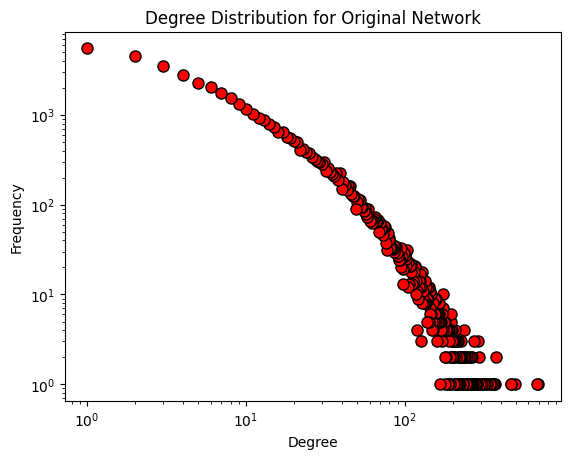

1.991029432150231

In [8]:
import math
import random
import collections

def power_law(G, kmin=10):
    """ Calculate the power-law exponent for the network. """
    n = 0
    sumk = 0
    for _, k in G.degree():
        if k >= kmin:
            sumk += math.log(k)
            n += 1
    return 1 + n / (sumk - n * math.log(kmin - 0.5)) if n > 0 else math.nan

def plot_degree_distribution(G):
    """ Plot the degree distribution of the network on a log-log scale. """
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degree_count = collections.Counter(degree_sequence)
    deg, cnt = zip(*degree_count.items())
    
    fig, ax = plt.subplots()
    ax.loglog(deg, cnt, marker="o", linestyle='None', markersize=8, markeredgecolor='black', markerfacecolor='red')
    ax.set_title(f"Degree Distribution for {G.name}")
    ax.set_xlabel("Degree")
    ax.set_ylabel("Frequency")
    
    plt.show()

# Load the network from the file
file_path = 'Networks/730.net'
G = nx.Graph()

with open(file_path, 'r') as file:
    n = int(file.readline().split()[1])
    for line in file:
        if line.startswith("*Edges"):
            break
    for line in file:
        i, j = map(int, line.split())
        G.add_edge(i - 1, j - 1)  # convert 1-based to 0-based

G.name = "Original Network"

# Calculate power-law exponent
gamma = power_law(G)

# Plot the degree distribution of the original network
plot_degree_distribution(G)

gamma

To determine if your network is scale-free, we typically look for certain characteristics in its degree distribution. Scale-free networks are known for their power-law degree distribution, meaning a few nodes (hubs) have a significantly higher number of connections compared to most other nodes, which have relatively few links

- The power-law exponent (gamma) of your network was found to be approximately 1.99. Generally, in a scale-free network, the degree distribution follows a power-law, 

p(k)∝k^(−γ), where γ typically ranges between 2 and 3.
Gamma value is very close to 2, this suggests that our network does exhibit characteristics of a scale-free network. 